In [1]:
import numpy as np
import pandas as pd
import pickle
import time

from sklearn.model_selection import train_test_split

from text_models import TextClassifier, extract_text_blocks, tokenize_data, load_glove_embedding
from lstm_attention_model import AttentionLSTM, train_part, evaluate, predict_labels
from helper import Dataset, plot_graphs, progress_bar, consolidate_results
%load_ext autoreload
%autoreload 2

# Load Dataset 

The dataset is a pandas dataframe with two columns: Text labels and the text sentences and sub-sentences. There are 8 different categories(labels) in total. Each sentence could also have multiple categories(labels) associated with it.

In [2]:
df = pickle.load( open( "review_labelled.pkl", "rb" ))

In [3]:
df.sample(10)

,label,pp_sent
158379,[management],they are very good at communicating the curren...
23660,[salary_benefits],free snacks
173012,[tech_product],interesting projects
226692,[business_vision_competitors],a vision for the future
184856,[business_vision_competitors],forward thinking employees
34312,[tech_product],tesla gives its interns the opportunity to per...
6273,[salary_benefits],ping pong
27441,[culture_team],great co workers
40975,"[salary_benefits, wlb_working_conditions]",excellent setup company with plenty of fun act...
45222,[Job Security/Advancement],plenty of departments to move around in if you...


Check for category imbalances in our dataset. Dataset looks well balanced in this case.

In [4]:
from collections import Counter
label_count = Counter([category for sublist in df.label.to_numpy() for category in sublist])
label_count

Counter({'Job Security/Advancement': 1151,
         'business_vision_competitors': 1042,
         'culture_team': 1148,
         'wlb_working_conditions': 1013,
         'salary_benefits': 1019,
         'management': 1064,
         'tech_product': 1009,
         'haras_discrim_sexism': 1001})

# Data Preparation

In [5]:
X, y, tokenizer, label_index = tokenize_data(df['pp_sent'].values, df['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# Split data into batches of 64
train_dset = Dataset(X_train, y_train, batch_size=64, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=64, shuffle=True)
test_dset = Dataset(X_test, y_test, batch_size=64)

Shape of data tensor: (8000,)
Found 3796 unique tokens.


In [6]:
# This variable holds the test results for all the models for later comparison.
model_results = []

# Train LSTM

Train a Multilabel text classifier using LSTM. This model has the following architecture: <br>
Input -> Word Embedding Layer -> LSTM -> Spatial Dropout -> Fully Connected -> RELU -> Fully Connected -> Sigmoid <br>
Here the LSTM output to the next fully connected layer is from the last time step only. All the model implementations could be found at text_models.py

In [7]:
model_lstm = TextClassifier(tokenizer, label_index)

history_lstm = model_lstm.train(X_train, y_train, 'LSTM', epochs = 10)
model_lstm.model.summary()

W0215 20:19:27.872645 4564635072 deprecation.py:506] From /Users/kshitijsharma/Documents/CS231n/assignment2/.env/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4081: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 3600 samples, validate on 1200 samples
Epoch 1/10
3600/3600 [==============================] - 12s 3ms/sample - loss: 0.4568 - binary_accuracy: 0.8540 - val_loss: 0.3881 - val_binary_accuracy: 0.8685
Epoch 2/10
3600/3600 [==============================] - 11s 3ms/sample - loss: 0.3862 - binary_accuracy: 0.8680 - val_loss: 0.3777 - val_binary_accuracy: 0.8685
Epoch 3/10
3600/3600 [==============================] - 11s 3ms/sample - loss: 0.3534 - binary_accuracy: 0.8683 - val_loss: 0.3087 - val_binary_accuracy: 0.8772
Epoch 4/10
3600/3600 [==============================] - 11s 3ms/sample - loss: 0.2636 - binary_accuracy: 0.8926 - val_loss: 0.2107 - val_binary_accuracy: 0.9234
Epoch 5/10
3600/3600 [==============================] - 10s 3ms/sample - loss: 0.1781 - binary_accuracy: 0.9345 - val_loss: 0.1475 - val_binary_accuracy: 0.9524
Epoch 6/10
3600/3600 [==============================] - 10s 3ms/sample - loss: 0.1123 - binary_accuracy: 0.9683 - val_loss: 0.0989 - val_binary_acc

Evaluate Model

In [8]:
test_loss_lstm, test_acc_lstm = model_lstm.evaluate(X_test,y_test)
print('Test Loss: {}'.format(test_loss_lstm))
print('Test Accuracy: {}'.format(test_acc_lstm))

1600/1600 [==============================] - 1s 588us/sample - loss: 0.0687 - binary_accuracy: 0.9820
Test Loss: 0.06872728250920773
Test Accuracy: 0.9819531440734863


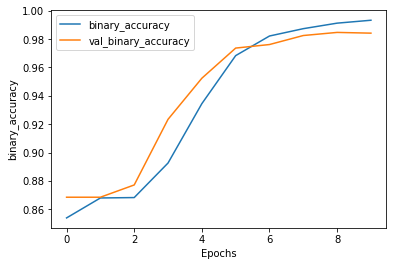

In [9]:
plot_graphs(history_lstm, 'binary_accuracy')

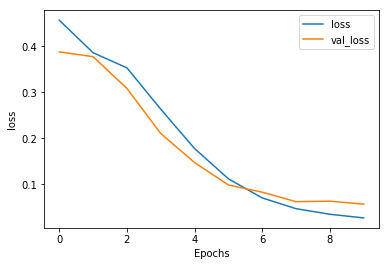

In [10]:
plot_graphs(history_lstm, 'loss')

In [11]:
h_lstm = consolidate_results(history_lstm, test_loss_lstm, test_acc_lstm, 'binary_accuracy', 'LSTM')
model_results.append(h_lstm)

# Train CNN

Model Architecture: <br> Input -> Word Embedding Layer -> Convolution Layer -> RELU -> Global Max Pool -> Fully Connected -> Sigmoid 

In [12]:
model_cnn = TextClassifier(tokenizer, label_index)

history_cnn = model_cnn.train(X_train, y_train, 'CNN', epochs = 10)
model_cnn.model.summary()

Train on 3600 samples, validate on 1200 samples
Epoch 1/10
3600/3600 [==============================] - 1s 403us/sample - loss: 0.4765 - binary_accuracy: 0.8545 - val_loss: 0.3699 - val_binary_accuracy: 0.8685
Epoch 2/10
3600/3600 [==============================] - 1s 349us/sample - loss: 0.3178 - binary_accuracy: 0.8779 - val_loss: 0.2297 - val_binary_accuracy: 0.9069
Epoch 3/10
3600/3600 [==============================] - 1s 352us/sample - loss: 0.1465 - binary_accuracy: 0.9458 - val_loss: 0.0858 - val_binary_accuracy: 0.9747
Epoch 4/10
3600/3600 [==============================] - 1s 349us/sample - loss: 0.0542 - binary_accuracy: 0.9845 - val_loss: 0.0495 - val_binary_accuracy: 0.9836
Epoch 5/10
3600/3600 [==============================] - 1s 350us/sample - loss: 0.0272 - binary_accuracy: 0.9927 - val_loss: 0.0381 - val_binary_accuracy: 0.9874
Epoch 6/10
3600/3600 [==============================] - 1s 354us/sample - loss: 0.0161 - binary_accuracy: 0.9967 - val_loss: 0.0325 - val_bina

Evaluate CNN Model

In [13]:
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(X_test,y_test)
print('Test Loss: {}'.format(test_loss_cnn))
print('Test Accuracy: {}'.format(test_acc_cnn))

1600/1600 [==============================] - 0s 67us/sample - loss: 0.0283 - binary_accuracy: 0.9909
Test Loss: 0.028251617536880075
Test Accuracy: 0.9909374713897705


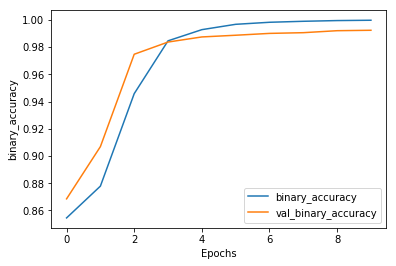

In [14]:
plot_graphs(history_cnn, 'binary_accuracy')

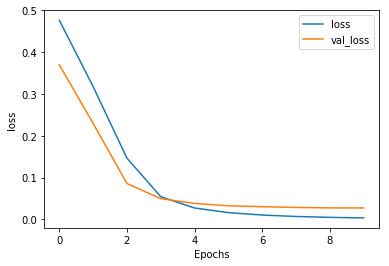

In [15]:
plot_graphs(history_cnn, 'loss')

In [16]:
h_cnn = consolidate_results(history_cnn, test_loss_cnn, test_acc_cnn, 'binary_accuracy', 'CNN')
model_results.append(h_cnn)

# Train CNN Glove

Model Architecture: 
Input -> GLoVe Word Embedding(Non trainable)  -> Convolution Layer -> RELU -> Global Max Pool -> Fully Connected -> Sigmoid

In [17]:
model_cnn_glove = TextClassifier(tokenizer, label_index)

history_cnn_glove = model_cnn_glove.train(X_train, y_train, 'CNN_Glove', epochs = 10)
model_cnn_glove.model.summary()

Train on 3600 samples, validate on 1200 samples
Epoch 1/10
3600/3600 [==============================] - 1s 323us/sample - loss: 0.3055 - binary_accuracy: 0.8883 - val_loss: 0.1828 - val_binary_accuracy: 0.9431
Epoch 2/10
3600/3600 [==============================] - 1s 263us/sample - loss: 0.1427 - binary_accuracy: 0.9541 - val_loss: 0.1194 - val_binary_accuracy: 0.9611
Epoch 3/10
3600/3600 [==============================] - 1s 266us/sample - loss: 0.0939 - binary_accuracy: 0.9714 - val_loss: 0.0950 - val_binary_accuracy: 0.9682
Epoch 4/10
3600/3600 [==============================] - 1s 266us/sample - loss: 0.0691 - binary_accuracy: 0.9800 - val_loss: 0.0772 - val_binary_accuracy: 0.9741
Epoch 5/10
3600/3600 [==============================] - 1s 262us/sample - loss: 0.0520 - binary_accuracy: 0.9862 - val_loss: 0.0692 - val_binary_accuracy: 0.9766
Epoch 6/10
3600/3600 [==============================] - 1s 265us/sample - loss: 0.0400 - binary_accuracy: 0.9903 - val_loss: 0.0638 - val_bina

Evaluate Glove Model

In [18]:
test_loss_glove, test_acc_glove = model_cnn_glove.evaluate(X_test,y_test)
print('Test Loss: {}'.format(test_loss_glove))
print('Test Accuracy: {}'.format(test_acc_glove))

1600/1600 [==============================] - 0s 101us/sample - loss: 0.0529 - binary_accuracy: 0.9822
Test Loss: 0.05287746250629425
Test Accuracy: 0.9821875095367432


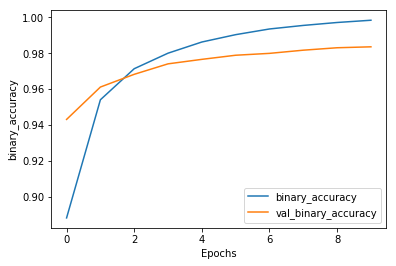

In [19]:
plot_graphs(history_cnn_glove, 'binary_accuracy')

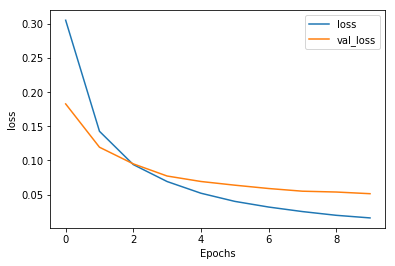

In [20]:
plot_graphs(history_cnn_glove, 'loss')

In [21]:
h_glove = consolidate_results(history_cnn_glove, test_loss_glove,
                           test_acc_glove, 'binary_accuracy', 'CNN GLoVe')
model_results.append(h_glove)

# Train MLP

Model Architecture: <br>
Input -> Word Embedding Layer -> 4x(Fully Connected -> RELU) -> Fully Connected -> Sigmoid <br>

In [22]:
model_mlp = TextClassifier(tokenizer, label_index)

history_mlp = model_mlp.train(X_train, y_train, 'MLP', epochs = 10)
model_mlp.model.summary()

Train on 3600 samples, validate on 1200 samples
Epoch 1/10
3600/3600 [==============================] - 1s 143us/sample - loss: 3.7338 - binary_accuracy: 0.7806 - val_loss: 1.1593 - val_binary_accuracy: 0.8461
Epoch 2/10
3600/3600 [==============================] - 0s 49us/sample - loss: 1.2104 - binary_accuracy: 0.8168 - val_loss: 0.9133 - val_binary_accuracy: 0.8627
Epoch 3/10
3600/3600 [==============================] - 0s 47us/sample - loss: 0.9428 - binary_accuracy: 0.8459 - val_loss: 0.8218 - val_binary_accuracy: 0.8661
Epoch 4/10
3600/3600 [==============================] - 0s 46us/sample - loss: 0.8183 - binary_accuracy: 0.8585 - val_loss: 0.7422 - val_binary_accuracy: 0.8683
Epoch 5/10
3600/3600 [==============================] - 0s 46us/sample - loss: 0.7275 - binary_accuracy: 0.8649 - val_loss: 0.6717 - val_binary_accuracy: 0.8684
Epoch 6/10
3600/3600 [==============================] - 0s 46us/sample - loss: 0.6641 - binary_accuracy: 0.8668 - val_loss: 0.6344 - val_binary_ac

Evaluate MLP Model

In [23]:
test_loss_mlp, test_acc_mlp = model_mlp.evaluate(X_test,y_test)
print('Test Loss: {}'.format(test_loss_mlp))
print('Test Accuracy: {}'.format(test_acc_mlp))

1600/1600 [==============================] - 0s 25us/sample - loss: 0.5485 - binary_accuracy: 0.8683
Test Loss: 0.5484774339199067
Test Accuracy: 0.8682812452316284


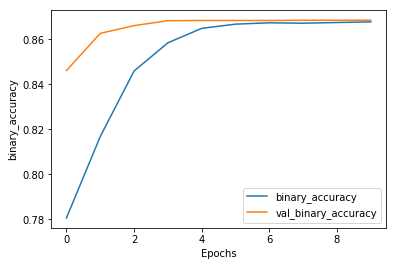

In [24]:
plot_graphs(history_mlp, 'binary_accuracy')

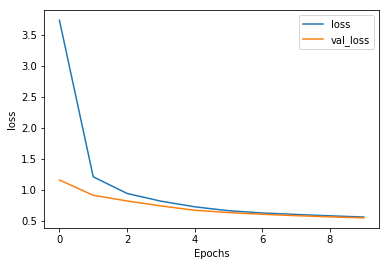

In [25]:
plot_graphs(history_mlp, 'loss')

In [26]:
h_mlp = consolidate_results(history_mlp, test_loss_mlp, test_acc_mlp, 'binary_accuracy', 'MLP')
model_results.append(h_mlp)

# LSTM with Attention

Model Architecture: 
Input -> Word Embedding Layer -> Bi-LSTM -> Attention layer -> Fully Connected -> Sigmoid 

In [27]:
sequence_length = 100
embedding_dim = 50
model_attention = AttentionLSTM(sequence_length, embedding_dim)

history_attention = train_part(model_attention, train_dset, val_dset, num_epochs=10, is_training=True)

Epoch 1, Loss: 0.4470841884613037, Accuracy: 86.03645324707031, Val Loss: 0.390531986951828, Val Accuracy: 86.734375
Epoch 2, Loss: 0.3951128423213959, Accuracy: 86.78125, Val Loss: 0.35704097151756287, Val Accuracy: 86.7421875
Epoch 3, Loss: 0.3341134786605835, Accuracy: 86.73697662353516, Val Loss: 0.29913437366485596, Val Accuracy: 87.671875
Epoch 4, Loss: 0.2600809633731842, Accuracy: 89.22395324707031, Val Loss: 0.2130773514509201, Val Accuracy: 91.3671875
Epoch 5, Loss: 0.19666379690170288, Accuracy: 92.4296875, Val Loss: 0.18286828696727753, Val Accuracy: 92.8359375
Epoch 6, Loss: 0.16616038978099823, Accuracy: 94.23698425292969, Val Loss: 0.1499485969543457, Val Accuracy: 94.59375
Epoch 7, Loss: 0.1197015643119812, Accuracy: 96.70833587646484, Val Loss: 0.10445407032966614, Val Accuracy: 96.84375
Epoch 8, Loss: 0.08721920847892761, Accuracy: 97.953125, Val Loss: 0.09239151328802109, Val Accuracy: 97.203125
Epoch 9, Loss: 0.0675198882818222, Accuracy: 98.64323425292969, Val Loss

Evaluate model

In [28]:
test_loss_attention, test_acc_attention = evaluate(model_attention, test_dset)
print('Test Loss: {}'.format(test_loss_attention))
print('Test Accuracy: {}'.format(test_acc_attention))

Test Loss: 0.08228757232427597
Test Accuracy: 0.9752343893051147


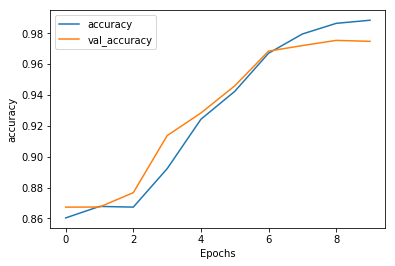

In [29]:
plot_graphs(history_attention, 'accuracy')

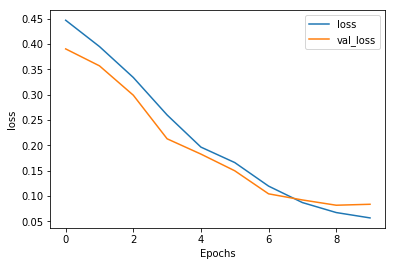

In [30]:
plot_graphs(history_attention, 'loss')

In [31]:
h_attention = consolidate_results(history_attention, test_loss_attention, test_acc_attention, 'accuracy', 'LSTM Attention')
model_results.append(h_attention)

# Comparison

Here before cross validation we can see LSTM, CNN, CNN Glove, LSTM Attention have very similar test accuracies. <br>
At this point we haven't done any cross validation so Val Accuracy and Test Accuracy have similar meaning.

In [32]:
col_names = ['Model', 'Train Accuracy', 'Val Accuracy', 'Test Accuracy', 'Train Loss', 'Val Loss', 'Test Loss']
comparison_df = pd.DataFrame(data=model_results, columns=col_names)
comparison_df

,Model,Train Accuracy,Val Accuracy,Test Accuracy,Train Loss,Val Loss,Test Loss
0,LSTM,99.326390,98.416668,98.195314,0.027260,0.057253,0.068727
1,CNN,99.965280,99.229169,99.093747,0.003413,0.027258,0.028252
2,CNN GLoVe,99.833333,98.354167,98.218751,0.015774,0.051266,0.052877
3,MLP,86.781251,86.854166,86.828125,0.562568,0.548357,0.548477
4,LSTM Attention,98.843747,97.476560,97.523439,0.056919,0.083853,0.082288


The cross_validation function iterates over different hyper parameter settings to find the best model configuration. This could easily be extended for more detailed paramter tuning.

In [33]:
def cross_validation(model_type, X_train, y_train, tokenizer, label_index):

    learning_rates = np.linspace(1e-3, 5e-4, 5)
    regularization_strengths = np.linspace(0.001, 1.5, 1)

    best_val = -1.
    best_train = -1
    best_model = None
    best_lr = None
    best_reg = None
    progress_counter = 0
    total_tests = learning_rates.shape[0] * regularization_strengths.shape[0]

    print('Cross validation : ', model_type)
    
    start_time = time.time()
    
    for lr in learning_rates:
        for reg in regularization_strengths:
            # Train the network
            model = TextClassifier(tokenizer, label_index, verbose=0)
            history = model.train(X_train, y_train, model_type, epochs=10,learning_rate=lr, regularization=reg)
            val_acc_history = history['val_binary_accuracy']
            val_acc = val_acc_history[-1]

            if val_acc > best_val:
                del best_model
                best_val = val_acc
                best_model = model
                best_lr = lr
                best_reg = reg
            else:
                del model
                
            progress_counter += 1    
            progress_bar(progress_counter, total_tests)
            
    best_hist = best_model.history
    
    train_acc, val_loss, train_loss = best_hist['binary_accuracy'][-1], best_hist['val_loss'][-1], best_hist['loss'][-1]

    print("Execution time: %s seconds" % (time.time() - start_time))
    print('Best validation accuracy: %f - Train accuracy: %f - val loss: %f - train loss: %f'
          % (best_val, train_acc, val_loss, train_loss) )
    print('Best learning rate: %f - regularization : %f' % (best_lr, best_reg) )
    return best_model

In [34]:
X, y, tokenizer, label_index = tokenize_data(df['pp_sent'].values, df['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

best_lstm = cross_validation("LSTM", X_train, y_train, tokenizer, label_index)
best_mlp = cross_validation("MLP", X_train, y_train, tokenizer, label_index)
best_cnn = cross_validation("CNN", X_train, y_train, tokenizer, label_index)
best_glove = cross_validation("CNN_Glove", X_train, y_train, tokenizer, label_index)
best_attention = cross_validation("Attention", X_train, y_train, tokenizer, label_index)

Shape of data tensor: (8000,)
Found 3796 unique tokens.
Cross validation :  LSTM
Status: [########################################] 5/5 
Execution time: 3046.7691781520844 seconds
Best validation accuracy: 0.987031 - Train accuracy: 0.993203 - val loss: 0.048529 - train loss: 0.024641
Best learning rate: 0.001000 - regularization : 0.001000
Cross validation :  MLP
Status: [########################################] 5/5 
Execution time: 30.611932039260864 seconds
Best validation accuracy: 0.868203 - Train accuracy: 0.867448 - val loss: 0.424215 - train loss: 0.428745
Best learning rate: 0.001000 - regularization : 0.001000
Cross validation :  CNN
Status: [########################################] 5/5 
Execution time: 121.08016109466553 seconds
Best validation accuracy: 0.993750 - Train accuracy: 0.999870 - val loss: 0.020990 - train loss: 0.002048
Best learning rate: 0.001000 - regularization : 0.001000
Cross validation :  CNN_Glove
Status: [########################################] 5/5 

In [35]:
test_loss, test_acc = best_cnn.evaluate(X_test,y_test)
print('CNN: Test Loss: {}'.format(test_loss))
print('CNN: Test Accuracy: {}'.format(test_acc))

test_loss, test_acc = best_glove.evaluate(X_test,y_test)
print('CNN Glove: Test Loss: {}'.format(test_loss))
print('CNN Glove: Test Accuracy: {}'.format(test_acc))

test_loss, test_acc = best_lstm.evaluate(X_test,y_test)
print('LSTM: Test Loss: {}'.format(test_loss))
print('LSTM: Test Accuracy: {}'.format(test_acc))

test_loss, test_acc = best_mlp.evaluate(X_test,y_test)
print('MLP: Test Loss: {}'.format(test_loss))
print('MLP: Test Accuracy: {}'.format(test_acc))

test_loss, test_acc = evaluate(best_attention.model, test_dset)
print('Attention: Test Loss: {}'.format(test_loss))
print('Attention: Test Accuracy: {}'.format(test_acc))

1600/1600 [==============================] - 0s 145us/sample - loss: 0.0241 - binary_accuracy: 0.9916
CNN: Test Loss: 0.02411823670612648
CNN: Test Accuracy: 0.9916406273841858
1600/1600 [==============================] - 0s 169us/sample - loss: 0.0467 - binary_accuracy: 0.9851
CNN Glove: Test Loss: 0.04670408125966787
CNN Glove: Test Accuracy: 0.9850780963897705
1600/1600 [==============================] - 2s 972us/sample - loss: 0.0560 - binary_accuracy: 0.9832
LSTM: Test Loss: 0.055990003990009425
LSTM: Test Accuracy: 0.983203113079071
1600/1600 [==============================] - 0s 35us/sample - loss: 0.4242 - binary_accuracy: 0.8680
MLP: Test Loss: 0.42418187856674194
MLP: Test Accuracy: 0.8680468797683716
Attention: Test Loss: 0.06052311509847641
Attention: Test Accuracy: 0.9811718463897705


The below code block loads a review, splits it into sentences and sub-sentences, and returns a flattened list

In [36]:
data_pros_cons = pickle.load( open( "review_pros_cons.pkl", "rb" ))
review = data_pros_cons.iloc[10,0]
blocks = extract_text_blocks(review)

Text example

In [37]:
print(review)

I worked for the internal marketing team (MarCom) on the creative side. The best thing about working at Apple is your coworkers. They do an excellent job of hiring incredibly intelligent, talented people. It's quite humbling to work alongside such accomplished people. You'll always feel like the dumbest person in the room, which is great because everyone has so much to teach you. Most of them are ego-free (about 70% of them) and will help you whenever possible. There are so many personality types, though nearly all of them are perfectionist Type A people. If that is your kind of crew, you'll do well.

The work usually comes in waves. When you're on, you're all the way on. For weeks at a time you can expect late nights and no weekends. On the flip side, when it's slow, it's very slow. You can often work from home or take comp days. During downtimes it is not uncommon to go in for five hours including a long lunch and then go home.

In addition to this, the compensation is good. The stoc

In [38]:
# Helper function to print sentences and categories from the prediction list
def print_categories_sentences(prediction_dict):
    
    if len(prediction_dict) == 0:
        print ("No predictions made")
        
    for k,v in predictions.items():
        categories = [i[1] for i in v[0]]
        sentence = v[1]
        print(categories, sentence)

# Predict


The predict function takes in a list of important text blocks as input, and returns a list of "useful/important" sentences with their categories and confidence values. <br>
Below we visualize the outputs of the 4 models on the text above(review).


## CNN

In [39]:
predictions = best_cnn.predict(blocks)
print_categories_sentences(predictions)

['culture_team'] They do an excellent job of hiring incredibly intelligent, talented people.
['Job Security/Advancement'] You'll always feel like the dumbest person in the room, which is great because everyone has so much to teach you.
['wlb_working_conditions'] The work usually comes in waves.
['wlb_working_conditions'] For weeks at a time you can expect late nights and no weekends.
['salary_benefits'] In addition to this, the compensation is good.
['salary_benefits'] The stock program is okay.
['culture_team'] Finally, Tim Cook seems like a genuinely good person.


## CNN Glove

In [40]:
predictions = best_glove.predict(blocks)
print_categories_sentences(predictions)

['culture_team'] They do an excellent job of hiring incredibly intelligent, talented people.
['wlb_working_conditions'] The work usually comes in waves.
['wlb_working_conditions'] For weeks at a time you can expect late nights and no weekends.
['wlb_working_conditions'] You can often work from home or take comp days.
['salary_benefits'] The stock program is okay.
['salary_benefits'] But the pay is more than fair and their annual reviews pretty much guarantee a raise, bonus, and/or more stock.
['culture_team'] Finally, Tim Cook seems like a genuinely good person.


## LSTM

In [41]:
predictions = best_lstm.predict(blocks)
print_categories_sentences(predictions)

['culture_team'] The best thing about working at Apple is your coworkers.
['culture_team'] They do an excellent job of hiring incredibly intelligent, talented people.
['culture_team'] It's quite humbling to work alongside such accomplished people.
['Job Security/Advancement'] You'll always feel like the dumbest person in the room, which is great because everyone has so much to teach you.
['salary_benefits'] Most of them are ego-free (about 70% of them) and will help you whenever possible.
['wlb_working_conditions'] For weeks at a time you can expect late nights and no weekends.
['Job Security/Advancement'] On the flip side, when it's slow, it's very slow.
['wlb_working_conditions'] You can often work from home or take comp days.
['wlb_working_conditions'] During downtimes it is not uncommon to go in for five hours including a long lunch and then go home.
['salary_benefits'] In addition to this, the compensation is good.
['salary_benefits'] The stock program is okay.
['salary_benefits']

## MLP

In [42]:
predictions = best_mlp.predict(blocks)
print_categories_sentences(predictions)

No predictions made


## LSTM with Attention

In [43]:
predictions = predict_labels(blocks, best_attention.model, tokenizer, label_index)
print_categories_sentences(predictions)

['culture_team'] The best thing about working at Apple is your coworkers.
['culture_team'] They do an excellent job of hiring incredibly intelligent, talented people.
['Job Security/Advancement'] There are so many personality types, though nearly all of them are perfectionist Type A people.
['wlb_working_conditions'] For weeks at a time you can expect late nights and no weekends.
['wlb_working_conditions'] You can often work from home or take comp days.
['salary_benefits'] The stock program is okay.
['salary_benefits'] But the pay is more than fair and their annual reviews pretty much guarantee a raise, bonus, and/or more stock.
['culture_team'] Finally, Tim Cook seems like a genuinely good person.


```python
print "Hello World"
```